### SHAP

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions (see papers for details and citations).

[see also](https://shap.readthedocs.io)

In [29]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import shap

plt.style.use("style/style.mplstyle")
shap.initjs()

# for plotting
alpha = 0.5
size = 15

In [30]:
# Directories
images_directory = "../images/aculei-images"
datasets_directory = "../feed-datasets"

In [31]:
# Seed
seed = 42

In [32]:
df = pd.read_pickle(datasets_directory + '/aculei-numerical.pkl')
df.head()

temperature  wild boar  porcupine       fox    badger    marten      wolf  \
0         25.0   0.970243   0.011796  0.011460  0.001555  0.001512  0.000991   
1         16.0   0.996869   0.002792  0.000112  0.000078  0.000033  0.000027   
2          9.0   0.084593   0.352572  0.188861  0.205791  0.131927  0.003121   
3         15.0   0.181697   0.263160  0.280894  0.010420  0.045404  0.011294   
4         19.0   0.000118   0.000149  0.942590  0.000321  0.048537  0.007341   

       deer      hare  squirrel  ...  season_winter  day_time_day  \
0  0.000947  0.000824  0.000282  ...              0             0   
1  0.000049  0.000013  0.000010  ...              0             0   
2  0.002608  0.004968  0.008771  ...              0             1   
3  0.020466  0.067673  0.004126  ...              0             1   
4  0.000033  0.000437  0.000366  ...              0             0   

   day_time_night  hunter_camera_1.0  hunter_camera_2.0  hunter_camera_3.0  \
0               1                  1                  0                  0   
1               1                  1                  0                  0   
2               0                  0                  0                  0   
3               0                  0                  0                  0   
4               1                  1                  0                  0   

   hunter_camera_4.0  hunter_camera_5.0  hunter_camera_6.0  hunter_camera_7.0  
0                  0                  0                  0                  0  
1                  0                  0                  0                  0  
2                  0                  0                  1                  0  
3                  0                  0                  1                  0  
4                  0                  0                  0                  0  

[5 rows x 29 columns]

In [33]:
print(df.temperature.max(), df.temperature.min())

36.0 -6.0


We use a scaler to scale the features because the temperature for example is in a range between -6 and +36 while the other features are between 0 and 1. This have been done also in the previous notebooks

In [34]:
import sklearn.preprocessing as preprocessing

x = df.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns=df.columns)

Fill temperature NaN using the mean value

In [35]:
mean_value = df.temperature.mean()
df.temperature.fillna(value=mean_value, inplace=True)

Perform the clusterization using KMeans algorrithm

In [36]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

K = 19
model = KMeans(n_clusters=K, random_state=seed)

# fitting data
model.fit(df)

# predictions
cluster_labels = model.predict(df)

# adding the results to the df cluster
df['cluster'] = cluster_labels

print(f'Silhoutte score: {silhouette_score(df, cluster_labels)}')

Silhoutte score: 0.7006145493312742


### Cat Boost classifier

References

- [Cat Boost](https://towardsdatascience.com/why-you-should-learn-catboost-now-390fb3895f76)
- [Article](https://medium.com/bricklane-tech/a-new-approach-to-clustering-interpretation-7729cb665ee8)

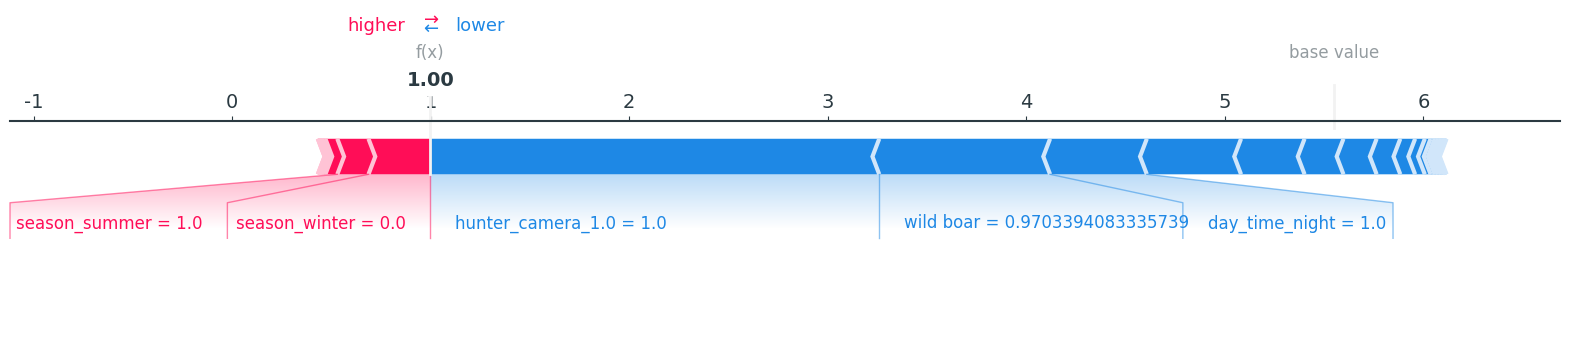

In [37]:
from catboost import CatBoostRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Using the labels produced with kmeans as targets
X = df.drop(columns=['cluster'])
y = df.cluster

catboost_model = CatBoostRegressor(iterations=300, learning_rate=0.1, random_seed=seed)
catboost_model.fit(X, y, verbose=False)

# Explain using shap
explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer(X)

shap.initjs()

# visualize the first prediction's explanation
shap.plots.force(shap_values[0, ...], matplotlib=True)

The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low)

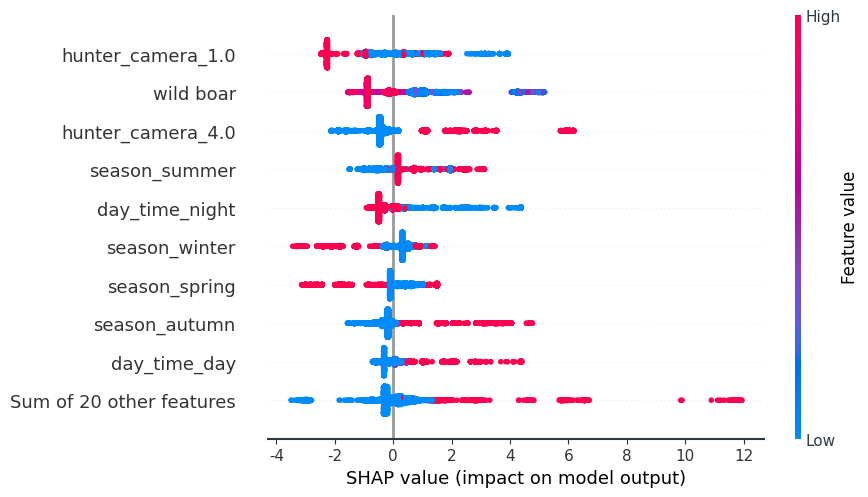

In [38]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

In [40]:
force_plot = shap.plots.force(shap_values[:2000])

from IPython.display import HTML
HTML(f"<div style='background-color:white;'>{shap.getjs() + force_plot.html()}</div>")

### Supervised clustering

There are two interrelated benefits to using SHAP values for cluster analysis:

- Computing SHAP values serves as a pre-processing step that rescales raw data into common units (the output of the supervised prediction model). This elegantly handles the common challenge where we want to cluster data containing features with very different units and scales (e.g. dollars, metres, colour etc.)
SHAP values weight the data by a measure of importance that emphasises the most informative features whilst minimising the influence of irrelevant features. Traditional clustering biases features based on the magnitude of their distributions, regardless of their actual information content. Using SHAP values de-noises the data of irrelevant information and amplifies features proportional to the signal that they generate.

- These properties lead to supervised clustering producing highly-differentiated, characterisable clusters that are easy to discern and interpret.

[reference](https://www.aidancooper.co.uk/supervised-clustering-shap-values/)